In [1]:
using Pkg
Pkg.activate(".")
using Statistics
using AdversarialAttacks
using BSON: @save, @load
using Images
using Plots
using Flux
using MLDatasets

  Activating project at `~/Documents/WS25/Julia/AdversarialAttacks.jl`


In [2]:
train_model = true

true

In [3]:
c10_train = MLDatasets.CIFAR10(:train)
c10_test = MLDatasets.CIFAR10(:test)

dataset CIFAR10:
  metadata  =>    Dict{String, Any} with 2 entries
  split     =>    :test
  features  =>    32×32×3×10000 Array{Float32, 4}
  targets   =>    10000-element Vector{Int64}

In [4]:
function preprocess(dataset)
    x, y = dataset[:]

    x = reshape(x, 32, 32, 3, :)

    # One-hot encode targets
    y = Flux.onehotbatch(y, 0:9)

    return x, y
end

preprocess (generic function with 1 method)

In [5]:
x_train, y_train = preprocess(c10_train)
x_test, y_test = preprocess(c10_test)

(Float32[0.61960787 0.59607846 … 0.23921569 0.21176471; 0.62352943 0.5921569 … 0.19215687 0.21960784; … ; 0.49411765 0.49019608 … 0.11372549 0.13333334; 0.45490196 0.46666667 … 0.078431375 0.08235294;;; 0.4392157 0.4392157 … 0.45490196 0.41960785; 0.43529412 0.43137255 … 0.4 0.4117647; … ; 0.35686275 0.35686275 … 0.32156864 0.32941177; 0.33333334 0.34509805 … 0.2509804 0.2627451;;; 0.19215687 0.2 … 0.65882355 0.627451; 0.18431373 0.15686275 … 0.5803922 0.58431375; … ; 0.14117648 0.1254902 … 0.49411765 0.5058824; 0.12941177 0.13333334 … 0.41960785 0.43137255;;;; 0.92156863 0.93333334 … 0.32156864 0.33333334; 0.90588236 0.92156863 … 0.18039216 0.24313726; … ; 0.9137255 0.9254902 … 0.7254902 0.7058824; 0.9098039 0.92156863 … 0.73333335 0.7294118;;; 0.92156863 0.93333334 … 0.3764706 0.39607844; 0.90588236 0.92156863 … 0.22352941 0.29411766; … ; 0.9137255 0.9254902 … 0.78431374 0.7647059; 0.9098039 0.92156863 … 0.7921569 0.78431374;;; 0.92156863 0.93333334 … 0.32156864 0.3254902; 0.90588236

In [11]:
function accuracy(model)
    # Use onecold to return class index
    ŷ = Flux.onecold(model(x_test))
    y = Flux.onecold(y_test)

    return mean(ŷ .== y)
end

accuracy (generic function with 1 method)

In [12]:
losses = Float32[]
if train_model
    println("Training model...")
    batchsize = 256
    train_loader = Flux.DataLoader((x_train, y_train); batchsize=batchsize, shuffle=true);
    model = Flux.Chain(
        Flux.Conv((3, 3), 3 => 32, pad=1, Flux.relu),
        Flux.Conv((3, 3), 32 => 32, pad=1, Flux.relu),
        Flux.MaxPool((2, 2)),

        Flux.Conv((3, 3), 32 => 64, pad=1, Flux.relu),
        Flux.Conv((3, 3), 64 => 64, pad=1, Flux.relu),
        Flux.MaxPool((2, 2)),

        Flux.flatten,
        Flux.Dense(8 * 8 * 64, 256, Flux.relu),
        Flux.Dense(256, 10),
    )
    loss_fn(ŷ, y) = Flux.logitcrossentropy(ŷ, y)
    optim = Flux.setup(Flux.Adam(0.001), model)

    for epoch in 1:5
        for (i, (x, y)) in enumerate(train_loader)
            loss, grads = Flux.withgradient(m -> loss_fn(m(x), y), model)
            Flux.update!(optim, model, grads[1])
            push!(losses, loss)
            if isone(i) || iszero(i % 50)
                acc = accuracy(model) * 100
                println("Epoch $epoch, step $i:\t loss = $(loss), acc = $(acc)%")
            end
        end
    end

    # Save the trained model
    @save "trained_model.bson" model
else
    # Reload the model from file
    @load "trained_model.bson" model
    println("Model loaded successfully!")
end

Training model...
Epoch 1, step 1:	 loss = 2.3055665, acc = 10.0%
Epoch 1, step 50:	 loss = 1.6690239, acc = 40.32%
Epoch 1, step 100:	 loss = 1.5637779, acc = 45.42%
Epoch 1, step 150:	 loss = 1.3714279, acc = 49.71%
Epoch 2, step 1:	 loss = 1.276307, acc = 54.49%
Epoch 2, step 50:	 loss = 1.2467427, acc = 56.330000000000005%
Epoch 2, step 100:	 loss = 1.1038541, acc = 56.769999999999996%
Epoch 2, step 150:	 loss = 1.035699, acc = 61.419999999999995%
Epoch 3, step 1:	 loss = 0.9099736, acc = 61.46%
Epoch 3, step 50:	 loss = 1.0286963, acc = 62.82%
Epoch 3, step 100:	 loss = 0.98762935, acc = 64.94%
Epoch 3, step 150:	 loss = 1.0159423, acc = 66.14999999999999%
Epoch 4, step 1:	 loss = 0.86312765, acc = 67.24%
Epoch 4, step 50:	 loss = 0.72793645, acc = 67.05%
Epoch 4, step 100:	 loss = 0.9412776, acc = 69.8%
Epoch 4, step 150:	 loss = 0.8707529, acc = 68.76%
Epoch 5, step 1:	 loss = 0.62608784, acc = 70.89%
Epoch 5, step 50:	 loss = 0.63044137, acc = 71.84%
Epoch 5, step 100:	 loss = 

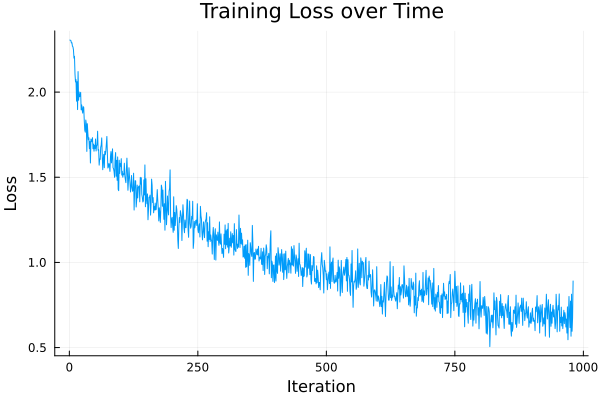

In [13]:
if train_model
    plot(losses, title="Training Loss over Time", xlabel="Iteration", ylabel="Loss", legend=false)
end

In [14]:
# Wrap the Flux model
flux_model = FluxModel(model)

# Select a single image (index 9) and keep batch dimension for the model
image_idx = 164
x_sample = Float32.(x_test[:, :, :, image_idx:image_idx])  # Shape: 32×32×3×1, convert to Float32
y_sample = y_test[:, image_idx]  # One-hot vector for this image

# Create FGSM attack 
fgsm = FGSM(Dict("epsilon" => 0.05))

# Generate adversarial example
sample = (data=x_sample, label=y_sample)
adv_sample = attack(fgsm, flux_model, sample)

32×32×3×1 Array{Float64, 4}:
[:, :, 1, 1] =
 0.377451   0.259804   0.187255  0.226471  …  0.330392  0.37549   0.273529
 0.306863   0.122549   0.171569  0.15         0.251961  0.271569  0.193137
 0.630392   0.126471   0.234314  0.165686     0.32451   0.216667  0.332353
 0.634314   0.448039   0.357843  0.310784     0.265686  0.348039  0.52451
 0.271569   0.57549    0.293137  0.269608     0.314706  0.495098  0.534314
 0.126471   0.165686   0.30098   0.538235  …  0.510784  0.516667  0.497059
 0.218627   0.126471   0.369608  0.834314     0.404902  0.351961  0.308824
 0.134314   0.177451   0.483333  0.616667     0.255882  0.267647  0.348039
 0.19902    0.310784   0.712745  0.565686     0.37549   0.469608  0.504902
 0.297059   0.165686   0.528431  0.642157     0.281373  0.348039  0.338235
 ⋮                                         ⋱            ⋮         
 0.146078   0.395098   0.395098  0.273529     0.561765  0.491176  0.428431
 0.259804   0.414706   0.306863  0.29902      0.59902   0.493137 

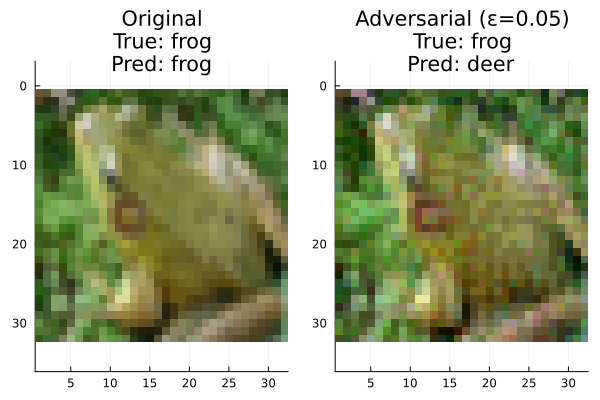

In [15]:
# Get predictions
original_pred = model(x_sample)
adv_pred = model(adv_sample)

# Convert to class labels
original_class = Flux.onecold(original_pred, 0:9)[1]
adv_class = Flux.onecold(adv_pred, 0:9)[1]
true_class = Flux.onecold(y_sample, 0:9)

# CIFAR-10 class names
class_names = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Extract single images (remove batch dimension)
img_original = x_sample[:, :, :, 1]  # 32x32x3
img_adv = adv_sample[:, :, :, 1]     # 32x32x3

# Clamp to valid range [0, 1]
img_original = clamp.(img_original, 0f0, 1f0)
img_adv = clamp.(img_adv, 0f0, 1f0)

# Convert to RGB format for display (CHW to CWH for colorview)
img_orig_rgb = colorview(RGB, permutedims(img_original, (3, 2, 1)))
img_adv_rgb = colorview(RGB, permutedims(img_adv, (3, 2, 1)))

# Plot side by side
p1 = plot(img_orig_rgb, 
          title="Original\nTrue: $(class_names[true_class+1])\nPred: $(class_names[original_class+1])")
p2 = plot(img_adv_rgb,
          title="Adversarial (ε=$(fgsm.parameters["epsilon"]))\nTrue: $(class_names[true_class+1])\nPred: $(class_names[adv_class+1])")

plot(p1, p2)